# MNIST - Deep Neural Network with Keras

In this Jupyter Notebook, we explore training and tuning a neural network using Keras, with a specific focus on the MNIST dataset.

* The problem we are trying to solve here is to classify grayscale images of handwritten digits (28 pixels by 28 pixels), into their 10 categories (0 to 9). 
* The dataset we will use is the **MNIST dataset**, a classic dataset in the machine learning community, which has been around for almost as long as the field itself and has been very intensively studied. 
* It's a set of 60,000 training images, plus 10,000 test images, assembled by the National Institute of Standards and Technology (the NIST in MNIST) in the 1980s. 

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt
from build_nn.py import build_deep_nn

## Load the dataset
(train_images, train_labels),(test_images, test_labels) = mnist.load_data()

## 1. Data Overview
Let's quickly view attributes of the MNIST data.

In [2]:
print("The number of images in the training dataset:",train_images.shape[0])
print("Width of each image in pixels:",train_images.shape[1])
print("Height of each image in pixels:",train_images.shape[2])

The number of images in the training dataset: 60000
Width of each image in pixels: 28
Height of each image in pixels: 28


In [3]:
from collections import Counter

print("The number of unique labels in training dataset\n", Counter(train_labels))
print("\nThe number of unique labels in test dataset\n", Counter(test_labels))

The number of unique labels in training dataset
 Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})

The number of unique labels in test dataset
 Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})


Let's view 30 random images

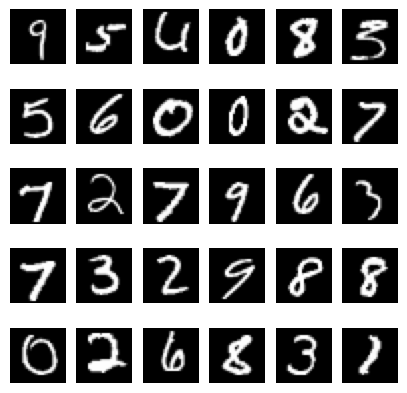

In [4]:
import matplotlib.pyplot as plt
import numpy as np
# sample 25 mnist digits from train dataset
indexes = np.random.randint(0, train_images.shape[0], size=30)
images = train_images[indexes]
labels = train_labels[indexes]


# plot the 25 mnist digits
plt.figure(figsize=(5,5))
for i in range(len(indexes)):
    plt.subplot(5, 6, i + 1)
    image = images[i]
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
plt.show()

--- 
## 2. Train Neural Network

### One-hot vetor

- At this point, the labels are in digits format, 0 to 9.

- This sparse scalar representation of labels is not suitable for the neural network prediction layer that outputs probabilities per class.

- A more suitable format is called a one-hot vector, a 10-dim vector with all elements 0, except for the index of the digit class.

- For example, if the label is 2, the equivalent one-hot vector is [0,0,1,0,0,0,0,0,0,0]. The first label has index 0.

- The following lines convert each label into a one-hot vector:

In [5]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the labels
train_labels = to_categorical(train_labels, num_classes=10)
test_labels = to_categorical(test_labels, num_classes=10)

Next, we will perform hyperparameter tuning to build and optimize a deep neural network for classifying handwritten digits. Our goal is to identify the best model architecture and hyperparameters that achieve the highest accuracy on the validation set for the MNIST classification problem.

We have already constructed the neural network model using specified layer options and encapsulated it in a function within the `build_nn.py` file. Instead of running the code again, we'll reuse the function directly in this Jupyter notebook. To provide clarity on the model structure, I’ve copied and pasted the function below.

``` def build_deep_nn(rows, columns, channels, layer_options):
     model = Sequential()
    
     # Flatten input
     model.add(Flatten(input_shape=(rows, columns, channels)))
    
     # Add hidden layers based on layer_options
     for hidden_size, activation, dropout_rate in layer_options:
        model.add(Dense(hidden_size, activation=activation))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    
     # Output layer (MNIST has 10 classes)
     model.add(Dense(10, activation='softmax'))
    
     # Compile the model
     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
     return model
```

In the next step, we build a function `build_model`which acts as a wrapper around `build_deep_nn` to facilitate hyperparameter tuning. It defines the structure of the layer_options dynamically based on the hyperparameters provided by the tuner.

In [6]:
def build_model(hp):
    # Define the layer options, and the hyperparameters tuning process will identifying the best combination of hyperparameters
    hidden_layers = hp.Int('hidden_layers', min_value=1, max_value=3)
    hidden_size = hp.Choice('hidden_size', values=[64, 128, 256, 512])
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    activation_functions = ['relu', 'sigmoid', 'elu', 'tanh']
    
    # Create the layer options list with varying activation functions
    layer_options = []
    for i in range(hidden_layers - 1):
        activation = hp.Choice(f'activation_{i}', values=activation_functions)
        layer_options.append((hidden_size, activation, 0)) ## Previous layers have no dropout rate
    
    last_activation = hp.Choice(f'activation_{hidden_layers - 1}', values=activation_functions) ## last layer
    layer_options.append((hidden_size, last_activation, dropout_rate)) ## last hidden layers have a dropout rate
    
    # Build the model using the build_deep_nn function
    model = build_deep_nn(28, 28, 1, layer_options)
    
    return model

The `RandomSearch` tuner from keras_tuner is used to search for the best combination of hyperparameters (number of hidden layers, hidden layer size, dropout rate, and activation functions) that maximizes validation accuracy on the MNIST dataset.

In [8]:
from keras_tuner import RandomSearch, Objective
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the tuner for hyperparameter search
tuner = RandomSearch(
    build_model,  # The function to build models
    objective=Objective("val_accuracy", direction="max"),  # Objective to maximize accuracy
    max_trials=20,  # Number of different models to try
    executions_per_trial=1,  # Number of times to train the model for each trial
    directory='random_search',  # Directory to store the search results
    project_name='mnist_classification'  # Name of the project
)

# Set up callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Modify the tuner search call to include the custom callback
tuner.search(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels), verbose=1,
             callbacks=[early_stopping, reduce_lr])

Trial 20 Complete [00h 00m 18s]
val_accuracy: 0.9376000165939331

Best val_accuracy So Far: 0.9521999955177307
Total elapsed time: 00h 07m 22s


In [10]:
# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the validation set
test_loss, test_acc = best_model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy of the optimal model: {test_acc:.4f}")

c:\Users\HA VINH NGUYEN\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


313/313 - 1s - 2ms/step - accuracy: 0.9522 - loss: 0.2303
Test accuracy of the optimal model: 0.9522


In [11]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters for the model
print(f"The best number of hidden layers is {best_hps.get('hidden_layers')}")
print(f"The best hidden layer size is {best_hps.get('hidden_size')}")
print(f"The best dropout rate is {best_hps.get('dropout_rate')}")

# Print the best activation function for each hidden layer
num_hidden_layers = best_hps.get('hidden_layers')
for i in range(num_hidden_layers):
    print(f"The best activation function for hidden layer {i+1} is {best_hps.get(f'activation_{i}')}")

The best number of hidden layers is 2
The best hidden layer size is 512
The best dropout rate is 0.30000000000000004
The best activation function for hidden layer 1 is relu
The best activation function for hidden layer 2 is elu


In [ ]:
# import os
# import tensorflow as tf

# # Suppress TensorFlow logs
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# tf.get_logger().setLevel('ERROR')

# best_model = tuner.get_best_models(num_models=1)[0]

# # Create a directory named 'NN' 
# model_save_dir = os.path.join(os.getcwd(), 'NN')
# os.makedirs(model_save_dir, exist_ok=True)

# # Save the best model
# model_save_path = os.path.join(model_save_dir, 'best_model.keras')
# best_model.save(model_save_path)

In [ ]:
# Load the saved model
## model_path = "NN/best_model.keras"
## loaded_model = keras.models.load_model(model_path)

c:\Users\HA VINH NGUYEN\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
